# Imports

In [2]:
import time
import torch.nn as nn
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
import pytorch_ssim  # For SSIM calculation
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
import os
import numpy as np

from torchvision import transforms
from torchmetrics.functional import structural_similarity_index_measure
from torchmetrics.functional import structural_similarity_index_measure as compute_ssim

c:\Users\zeina\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Dataset Preproccessing

##### DIV2K dataset is used

In [ ]:
# This is run only once
from PIL import Image
import os

def center_crop_images(dataset_path):
    # List all image files in the dataset
    image_files = [f for f in os.listdir(dataset_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    
    # Initialize variables to store the minimum width and height
    min_width = float('inf')
    min_height = float('inf')
    
    # Find the smallest image dimensions
    for image_file in image_files:
        with Image.open(os.path.join(dataset_path, image_file)) as img:
            width, height = img.size
            min_width = min(min_width, width)
            min_height = min(min_height, height)
    
    # Center crop all images to the size of the smallest image
    for image_file in image_files:
        with Image.open(os.path.join(dataset_path, image_file)) as img:
            width, height = img.size
            # Calculate the cropping box (center crop)
            left = (width - min_width) // 2
            top = (height - min_height) // 2
            right = left + min_width
            bottom = top + min_height
            
            # Crop and save the image
            cropped_img = img.crop((left, top, right, bottom))
            cropped_img.save(os.path.join(dataset_path, f"cropped_{image_file}"))

# Crops all images in the dataset and saving them, original images were deleted manually by me
dataset_path = "./DIV2K_train_HR_Cropped"
center_crop_images(dataset_path)

## Synthetic LR Image Creation

In [2]:
class SRDataset(Dataset):
    def __init__(self, root_dir, transform=None, scale=4):
        self.files = sorted(os.listdir(root_dir))
        self.root_dir = root_dir
        self.transform = transform
        self.scale = scale

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        path = os.path.join(self.root_dir, self.files[idx])
        img = Image.open(path).convert('RGB')  # Change from 'L' to 'RGB' for color images

        hr = img
        lr = hr.resize((hr.width // self.scale, hr.height // self.scale), Image.BICUBIC)
        lr = lr.resize((hr.width, hr.height), Image.BICUBIC)

        if self.transform:
            hr = self.transform(hr)
            lr = self.transform(lr)

        return lr, hr

In [3]:
    # Transform to convert images to tensors
transform = transforms.ToTensor()

    # Load the full dataset (800 images assumed)
full_dataset = SRDataset("./DIV2K_train_HR_Cropped", transform=transform, scale=4)

    # Split sizes (e.g., 90% train, 10% val)
train_size = int(0.9 * len(full_dataset))  # 720
val_size = len(full_dataset) - train_size  # 80

    # Split the dataset randomly
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

    # Dataloaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=1)
    

torch.Size([3, 648, 1116])


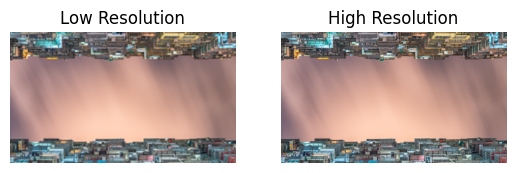

Difference shape: torch.Size([1, 3, 648, 1116])
Difference: tensor([[[[-0.0941, -0.0863, -0.0824,  ..., -0.0431,  0.1176,  0.1647],
          [-0.0863, -0.0902, -0.1373,  ...,  0.0745,  0.1098,  0.0314],
          [ 0.0392,  0.0431, -0.0314,  ..., -0.0314, -0.0588, -0.0706],
          ...,
          [-0.0784, -0.0667, -0.0627,  ..., -0.0627, -0.0314,  0.0471],
          [-0.0196, -0.0196, -0.0078,  ..., -0.0549, -0.0431, -0.0745],
          [-0.0549, -0.0392, -0.0392,  ...,  0.0667,  0.1216, -0.0392]],

         [[-0.2157, -0.2000, -0.2000,  ..., -0.0471,  0.1294,  0.1725],
          [-0.1451, -0.1569, -0.1569,  ...,  0.0745,  0.1137,  0.0353],
          [ 0.0784,  0.0706,  0.0510,  ..., -0.0392, -0.0627, -0.0627],
          ...,
          [-0.0941, -0.0824, -0.0745,  ..., -0.0980, -0.0196,  0.0824],
          [-0.0275, -0.0235, -0.0078,  ..., -0.1020, -0.0863, -0.1216],
          [-0.0667, -0.0392, -0.0353,  ...,  0.0392,  0.1882, -0.0157]],

         [[-0.2431, -0.2275, -0.2275,  ...

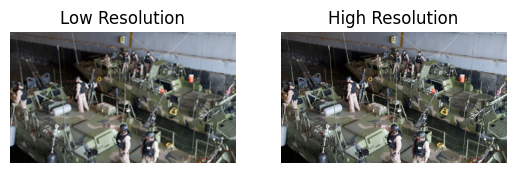

Difference shape: torch.Size([1, 3, 648, 1116])
Difference: tensor([[[[ 0.0078,  0.0157,  0.0235,  ..., -0.0039,  0.0000, -0.0039],
          [ 0.0157,  0.0353,  0.0353,  ...,  0.0039,  0.0039, -0.0039],
          [-0.0118, -0.0078, -0.0039,  ...,  0.0078, -0.0039, -0.0078],
          ...,
          [ 0.0039,  0.0000, -0.0039,  ..., -0.0196,  0.1216,  0.0784],
          [ 0.0000,  0.0039,  0.0000,  ..., -0.0863,  0.0902,  0.1098],
          [ 0.0000,  0.0118,  0.0000,  ..., -0.1216,  0.0196,  0.1137]],

         [[ 0.0118,  0.0157,  0.0235,  ..., -0.0039,  0.0000, -0.0039],
          [ 0.0235,  0.0431,  0.0392,  ...,  0.0039,  0.0039, -0.0039],
          [ 0.0118,  0.0078,  0.0078,  ...,  0.0078, -0.0039, -0.0078],
          ...,
          [ 0.0000,  0.0000,  0.0000,  ..., -0.0078,  0.1490,  0.1059],
          [-0.0039,  0.0000, -0.0039,  ..., -0.0863,  0.1098,  0.1412],
          [-0.0039,  0.0078, -0.0039,  ..., -0.1451,  0.0157,  0.1490]],

         [[ 0.0314,  0.0314,  0.0392,  ...

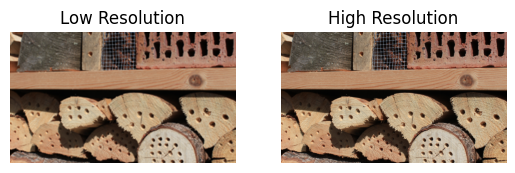

Difference shape: torch.Size([1, 3, 648, 1116])
Difference: tensor([[[[-0.0118, -0.0078, -0.0078,  ...,  0.0510, -0.1373, -0.2980],
          [-0.0118, -0.0039, -0.0118,  ...,  0.0314,  0.0039, -0.1412],
          [-0.0078, -0.0039,  0.0000,  ...,  0.0196, -0.0196, -0.0471],
          ...,
          [-0.0118,  0.0118,  0.0235,  ..., -0.0039, -0.0235, -0.0118],
          [-0.0275, -0.0235, -0.0196,  ..., -0.0863, -0.1020, -0.0706],
          [-0.0353, -0.0353, -0.0314,  ...,  0.0706,  0.0078, -0.1216]],

         [[-0.0118,  0.0039,  0.0118,  ...,  0.0549, -0.1216, -0.2118],
          [-0.0275, -0.0078,  0.0000,  ...,  0.0471, -0.0078, -0.1176],
          [-0.0353, -0.0118,  0.0000,  ...,  0.0275, -0.0275, -0.0353],
          ...,
          [-0.0157, -0.0039,  0.0157,  ..., -0.0353, -0.0510,  0.0000],
          [-0.0196, -0.0314, -0.0353,  ..., -0.1294, -0.1333, -0.0627],
          [-0.0235, -0.0353, -0.0431,  ...,  0.0902,  0.0078, -0.1490]],

         [[-0.0078,  0.0157,  0.0235,  ...

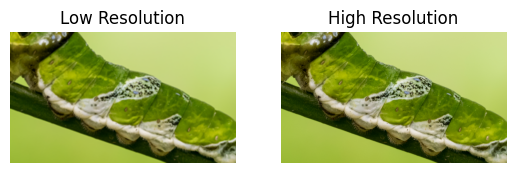

Difference shape: torch.Size([1, 3, 648, 1116])
Difference: tensor([[[[-0.0471, -0.0353, -0.0157,  ...,  0.0000,  0.0000,  0.0000],
          [-0.0235, -0.0196, -0.0118,  ..., -0.0039,  0.0000, -0.0039],
          [ 0.0000, -0.0196,  0.0078,  ...,  0.0000,  0.0000, -0.0039],
          ...,
          [ 0.0078,  0.0118, -0.0157,  ...,  0.0000, -0.0157, -0.0196],
          [-0.0039,  0.0039,  0.0000,  ..., -0.0078,  0.0157,  0.0000],
          [-0.0039,  0.0000, -0.0118,  ...,  0.0078,  0.0157, -0.0078]],

         [[-0.0549, -0.0392, -0.0196,  ...,  0.0000,  0.0000,  0.0000],
          [-0.0353, -0.0196, -0.0078,  ...,  0.0000,  0.0039,  0.0039],
          [-0.0039, -0.0196,  0.0118,  ...,  0.0000,  0.0039,  0.0039],
          ...,
          [ 0.0078,  0.0118, -0.0118,  ...,  0.0000, -0.0196, -0.0157],
          [ 0.0000,  0.0039,  0.0039,  ..., -0.0078,  0.0118,  0.0000],
          [ 0.0000,  0.0000, -0.0078,  ...,  0.0078,  0.0118, -0.0039]],

         [[-0.0078,  0.0078,  0.0039,  ...

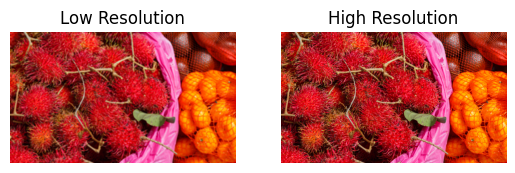

Difference shape: torch.Size([1, 3, 648, 1116])
Difference: tensor([[[[-0.0118, -0.0196, -0.0196,  ...,  0.1098,  0.1490,  0.1608],
          [-0.0039, -0.0078, -0.0118,  ..., -0.0196,  0.1608,  0.2039],
          [ 0.0118,  0.0000, -0.0039,  ..., -0.1490,  0.1333,  0.2588],
          ...,
          [ 0.0235,  0.0392, -0.0078,  ..., -0.0039,  0.0039,  0.0118],
          [ 0.0706,  0.0588, -0.0039,  ...,  0.0078,  0.0196,  0.0196],
          [ 0.0275,  0.0196, -0.0196,  ...,  0.0235,  0.0275,  0.0235]],

         [[-0.0039, -0.0078, -0.0196,  ...,  0.0588,  0.0431,  0.0431],
          [ 0.0118,  0.0078, -0.0078,  ...,  0.0078,  0.0549,  0.0745],
          [ 0.0314,  0.0118, -0.0118,  ..., -0.0588,  0.0471,  0.0824],
          ...,
          [ 0.0118,  0.0196, -0.0118,  ..., -0.0078, -0.0078,  0.0235],
          [ 0.0667,  0.0588,  0.0000,  ...,  0.0039,  0.0118,  0.0235],
          [ 0.0039,  0.0000,  0.0000,  ...,  0.0118,  0.0235,  0.0196]],

         [[ 0.0157, -0.0118, -0.0118,  ...

In [4]:
print(val_loader.dataset[0][0].shape)  # Check the shape of the first batch
# show images in val_loader
for i, (lr, hr) in enumerate(val_loader):
    if i == 5:
        break
    plt.subplot(1, 2, 1)
    plt.imshow(lr[0].permute(1, 2, 0).numpy())
    plt.title("Low Resolution")
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(hr[0].permute(1, 2, 0).numpy())
    plt.title("High Resolution")
    plt.axis('off')
    plt.show()
    difference = hr - lr
    print("Difference shape:", difference.shape) # if the difference is not 0, then the images are different
    print("Difference:", difference)  # Check the difference between HR and LR images

##### The difference between the images are very subtle because the scale is x4 but the images are indeed different. As shown in the inference cell, cv2 shows the difference between LR and HR more accurately. Note that the difference is more noticable than images with scale factor x2, and the numbers in the tensors are larger. 

# Model

In [5]:
class SRCNN(nn.Module):
    def __init__(self):
        super(SRCNN, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=9, padding=4),  # 3 for RGB input
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 32, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 3, kernel_size=5, padding=2)  # 3 for RGB output
        )

    def forward(self, x):
        return self.model(x)

# Evaluation Scoring Functions

In [6]:
import torch.nn as nn

class LossMSE(nn.Module):
    def __init__(self):
        super(LossMSE, self).__init__()
        self.mse_loss = nn.MSELoss()

    def forward(self, output, target):
        return self.mse_loss(output, target)


In [ ]:
# another loss function I tried but didn't cause any improvement between lr and sr images
# class SSIM_MSE_Loss(nn.Module):
#     def __init__(self, alpha=0.84, beta=0.16):
#         super(SSIM_MSE_Loss, self).__init__()
#         self.alpha = alpha
#         self.beta = beta
#         self.mse_loss = nn.MSELoss()

#     def forward(self, output, target):
#         ssim = structural_similarity_index_measure(output, target, data_range=1.0)
#         ssim_loss = 1 - ssim
#         mse_loss = self.mse_loss(output, target)
#         return self.alpha * ssim_loss + self.beta * mse_loss

In [7]:
def psnr(target, output, data_range=1.0):
    mse = np.mean((target - output) ** 2)
    if mse == 0:
        return 100
    return 20 * np.log10(data_range / np.sqrt(mse))

# Evaluation Function

In [8]:
def evaluate(model, dataloader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    psnr_scores = []
    ssim_scores = []

    with torch.no_grad():
        for lr_img, hr_img in dataloader:
            lr_img, hr_img = lr_img.to(device), hr_img.to(device)
            sr_img = model(lr_img).clamp(0.0, 1.0)
            
            psnr_val = psnr(hr_img.squeeze().cpu().numpy(), sr_img.squeeze().cpu().numpy())
            ssim_val = compute_ssim(sr_img, hr_img, data_range=1.0).item()
            
            psnr_scores.append(psnr_val)
            ssim_scores.append(ssim_val)

    return (
        sum(psnr_scores) / len(psnr_scores),
        sum(ssim_scores) / len(ssim_scores)
    )

## Plotting Graphs

In [9]:
def plot_learning_curve(epoch_losses, epoch_psnrs, epoch_ssims):
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(1, len(epoch_losses) + 1), epoch_losses, label='Training Loss', color='blue')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Curve')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(range(1, len(epoch_psnrs) + 1), epoch_psnrs, label='Validation PSNR', color='green')
    plt.xlabel('Epoch')
    plt.ylabel('PSNR')
    plt.title('Validation PSNR Curve')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    if epoch_ssims is not None:
        plt.figure(figsize=(6, 4))
        plt.plot(range(1, len(epoch_ssims) + 1), epoch_ssims, label='Validation SSIM', color='purple')
        plt.xlabel('Epoch')
        plt.ylabel('SSIM')
        plt.title('Validation SSIM Curve')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.savefig("ssim_curve.png")
        plt.show()

# Train Function

In [10]:
def train(model, train_dataloader, val_dataloader, epochs=5, lr=1e-4, log_dir="runs/SRCNNx4"):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    criterion = LossMSE()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    writer = SummaryWriter(log_dir)

    epoch_losses = []
    epoch_psnrs = []
    epoch_ssims = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0
        for lr_img, hr_img in tqdm(train_dataloader, desc=f"Epoch {epoch+1}"):
            lr_img, hr_img = lr_img.to(device), hr_img.to(device)

            output = model(lr_img)
            loss = criterion(output, hr_img)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_loss = running_loss / len(train_dataloader)
        epoch_losses.append(avg_loss)
        writer.add_scalar("Loss/Train", avg_loss, epoch)

        val_psnr, val_ssim = evaluate(model, val_dataloader)
        epoch_psnrs.append(val_psnr)
        epoch_ssims.append(val_ssim)
        writer.add_scalar("PSNR/Val", val_psnr, epoch)
        writer.add_scalar("SSIM/Val", val_ssim, epoch)


        model.eval()
        with torch.no_grad():
            for lr_img, hr_img in val_dataloader:
                lr_img = lr_img.to(device)
                output = model(lr_img).clamp(0.0, 1.0)
                writer.add_images("Input/LR", lr_img, epoch)
                writer.add_images("Output/SR", output, epoch)
                writer.add_images("Target/HR", hr_img.to(device), epoch)
                break  # Log only first batch

        print(f"Epoch {epoch+1}: Loss = {avg_loss:.4f}, PSNR = {val_psnr:.2f}, SSIM = {val_ssim:.4f}")

    writer.close()
    plot_learning_curve(epoch_losses, epoch_psnrs, epoch_ssims)
    return model

# Training The Model


Training SRCNN...


Epoch 1: 100%|██████████| 90/90 [00:35<00:00,  2.53it/s]
c:\Users\zeina\AppData\Local\Programs\Python\Python310\lib\site-packages\torchmetrics\utilities\prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(


Epoch 1: Loss = 0.0546, PSNR = 19.68, SSIM = 0.5445


Epoch 2: 100%|██████████| 90/90 [00:34<00:00,  2.60it/s]


Epoch 2: Loss = 0.0096, PSNR = 21.87, SSIM = 0.5933


Epoch 3: 100%|██████████| 90/90 [00:34<00:00,  2.58it/s]


Epoch 3: Loss = 0.0067, PSNR = 23.51, SSIM = 0.6494


Epoch 4: 100%|██████████| 90/90 [00:35<00:00,  2.55it/s]


Epoch 4: Loss = 0.0053, PSNR = 24.27, SSIM = 0.6749


Epoch 5: 100%|██████████| 90/90 [00:35<00:00,  2.50it/s]


Epoch 5: Loss = 0.0049, PSNR = 24.48, SSIM = 0.6809


Epoch 6: 100%|██████████| 90/90 [00:36<00:00,  2.46it/s]


Epoch 6: Loss = 0.0048, PSNR = 24.60, SSIM = 0.6842


Epoch 7: 100%|██████████| 90/90 [00:36<00:00,  2.44it/s]


Epoch 7: Loss = 0.0047, PSNR = 24.71, SSIM = 0.6875


Epoch 8: 100%|██████████| 90/90 [00:37<00:00,  2.41it/s]


Epoch 8: Loss = 0.0047, PSNR = 24.69, SSIM = 0.6905


Epoch 9: 100%|██████████| 90/90 [00:38<00:00,  2.36it/s]


Epoch 9: Loss = 0.0046, PSNR = 24.86, SSIM = 0.6935


Epoch 10: 100%|██████████| 90/90 [00:37<00:00,  2.40it/s]


Epoch 10: Loss = 0.0045, PSNR = 24.93, SSIM = 0.6961


Epoch 11: 100%|██████████| 90/90 [00:38<00:00,  2.37it/s]


Epoch 11: Loss = 0.0045, PSNR = 25.00, SSIM = 0.6987


Epoch 12: 100%|██████████| 90/90 [00:38<00:00,  2.35it/s]


Epoch 12: Loss = 0.0045, PSNR = 24.99, SSIM = 0.7009


Epoch 13: 100%|██████████| 90/90 [00:39<00:00,  2.31it/s]


Epoch 13: Loss = 0.0044, PSNR = 25.10, SSIM = 0.7029


Epoch 14: 100%|██████████| 90/90 [00:39<00:00,  2.27it/s]


Epoch 14: Loss = 0.0044, PSNR = 25.17, SSIM = 0.7047


Epoch 15: 100%|██████████| 90/90 [00:40<00:00,  2.22it/s]


Epoch 15: Loss = 0.0044, PSNR = 25.21, SSIM = 0.7062


Epoch 16: 100%|██████████| 90/90 [00:40<00:00,  2.23it/s]


Epoch 16: Loss = 0.0043, PSNR = 25.17, SSIM = 0.7076


Epoch 17: 100%|██████████| 90/90 [00:40<00:00,  2.23it/s]


Epoch 17: Loss = 0.0043, PSNR = 25.29, SSIM = 0.7091


Epoch 18: 100%|██████████| 90/90 [00:39<00:00,  2.29it/s]


Epoch 18: Loss = 0.0043, PSNR = 25.32, SSIM = 0.7103


Epoch 19: 100%|██████████| 90/90 [00:39<00:00,  2.27it/s]


Epoch 19: Loss = 0.0043, PSNR = 25.36, SSIM = 0.7113


Epoch 20: 100%|██████████| 90/90 [00:40<00:00,  2.25it/s]


Epoch 20: Loss = 0.0043, PSNR = 25.21, SSIM = 0.7116


Epoch 21: 100%|██████████| 90/90 [00:40<00:00,  2.23it/s]


Epoch 21: Loss = 0.0042, PSNR = 25.41, SSIM = 0.7133


Epoch 22: 100%|██████████| 90/90 [00:41<00:00,  2.19it/s]


Epoch 22: Loss = 0.0042, PSNR = 25.43, SSIM = 0.7140


Epoch 23: 100%|██████████| 90/90 [00:41<00:00,  2.19it/s]


Epoch 23: Loss = 0.0042, PSNR = 25.45, SSIM = 0.7149


Epoch 24: 100%|██████████| 90/90 [00:41<00:00,  2.17it/s]


Epoch 24: Loss = 0.0042, PSNR = 25.47, SSIM = 0.7156


Epoch 25: 100%|██████████| 90/90 [00:41<00:00,  2.19it/s]


Epoch 25: Loss = 0.0042, PSNR = 25.49, SSIM = 0.7162


Epoch 26: 100%|██████████| 90/90 [00:40<00:00,  2.20it/s]


Epoch 26: Loss = 0.0042, PSNR = 25.46, SSIM = 0.7164


Epoch 27: 100%|██████████| 90/90 [00:41<00:00,  2.19it/s]


Epoch 27: Loss = 0.0042, PSNR = 25.52, SSIM = 0.7173


Epoch 28: 100%|██████████| 90/90 [00:41<00:00,  2.18it/s]


Epoch 28: Loss = 0.0042, PSNR = 25.52, SSIM = 0.7176


Epoch 29: 100%|██████████| 90/90 [00:41<00:00,  2.16it/s]


Epoch 29: Loss = 0.0042, PSNR = 25.55, SSIM = 0.7181


Epoch 30: 100%|██████████| 90/90 [00:40<00:00,  2.23it/s]


Epoch 30: Loss = 0.0041, PSNR = 25.56, SSIM = 0.7185


Epoch 31: 100%|██████████| 90/90 [00:40<00:00,  2.21it/s]


Epoch 31: Loss = 0.0041, PSNR = 25.57, SSIM = 0.7188


Epoch 32: 100%|██████████| 90/90 [00:40<00:00,  2.22it/s]


Epoch 32: Loss = 0.0042, PSNR = 25.58, SSIM = 0.7190


Epoch 33: 100%|██████████| 90/90 [00:41<00:00,  2.18it/s]


Epoch 33: Loss = 0.0041, PSNR = 25.58, SSIM = 0.7193


Epoch 34: 100%|██████████| 90/90 [00:41<00:00,  2.19it/s]


Epoch 34: Loss = 0.0041, PSNR = 25.56, SSIM = 0.7195


Epoch 35: 100%|██████████| 90/90 [00:40<00:00,  2.21it/s]


Epoch 35: Loss = 0.0041, PSNR = 25.60, SSIM = 0.7198


Epoch 36: 100%|██████████| 90/90 [00:40<00:00,  2.21it/s]


Epoch 36: Loss = 0.0041, PSNR = 25.60, SSIM = 0.7202


Epoch 37: 100%|██████████| 90/90 [00:41<00:00,  2.17it/s]


Epoch 37: Loss = 0.0041, PSNR = 25.61, SSIM = 0.7200


Epoch 38: 100%|██████████| 90/90 [00:41<00:00,  2.17it/s]


Epoch 38: Loss = 0.0041, PSNR = 25.62, SSIM = 0.7208


Epoch 39: 100%|██████████| 90/90 [00:41<00:00,  2.18it/s]


Epoch 39: Loss = 0.0041, PSNR = 25.63, SSIM = 0.7208


Epoch 40: 100%|██████████| 90/90 [00:41<00:00,  2.17it/s]


Epoch 40: Loss = 0.0041, PSNR = 25.64, SSIM = 0.7213


Epoch 41: 100%|██████████| 90/90 [00:41<00:00,  2.19it/s]


Epoch 41: Loss = 0.0041, PSNR = 25.64, SSIM = 0.7214


Epoch 42: 100%|██████████| 90/90 [00:41<00:00,  2.16it/s]


Epoch 42: Loss = 0.0041, PSNR = 25.65, SSIM = 0.7216


Epoch 43: 100%|██████████| 90/90 [00:41<00:00,  2.16it/s]


Epoch 43: Loss = 0.0041, PSNR = 25.66, SSIM = 0.7220


Epoch 44: 100%|██████████| 90/90 [00:40<00:00,  2.21it/s]


Epoch 44: Loss = 0.0041, PSNR = 25.66, SSIM = 0.7223


Epoch 45: 100%|██████████| 90/90 [00:41<00:00,  2.18it/s]


Epoch 45: Loss = 0.0041, PSNR = 25.68, SSIM = 0.7229


Epoch 46: 100%|██████████| 90/90 [00:42<00:00,  2.13it/s]


Epoch 46: Loss = 0.0041, PSNR = 25.68, SSIM = 0.7232


Epoch 47: 100%|██████████| 90/90 [00:40<00:00,  2.20it/s]


Epoch 47: Loss = 0.0041, PSNR = 25.63, SSIM = 0.7231


Epoch 48: 100%|██████████| 90/90 [00:40<00:00,  2.23it/s]


Epoch 48: Loss = 0.0041, PSNR = 25.70, SSIM = 0.7238


Epoch 49: 100%|██████████| 90/90 [00:40<00:00,  2.22it/s]


Epoch 49: Loss = 0.0041, PSNR = 25.70, SSIM = 0.7240


Epoch 50: 100%|██████████| 90/90 [00:39<00:00,  2.25it/s]


Epoch 50: Loss = 0.0041, PSNR = 25.68, SSIM = 0.7240


Epoch 51: 100%|██████████| 90/90 [00:39<00:00,  2.25it/s]


Epoch 51: Loss = 0.0041, PSNR = 25.68, SSIM = 0.7241


Epoch 52: 100%|██████████| 90/90 [00:40<00:00,  2.22it/s]


Epoch 52: Loss = 0.0041, PSNR = 25.73, SSIM = 0.7246


Epoch 53: 100%|██████████| 90/90 [00:40<00:00,  2.23it/s]


Epoch 53: Loss = 0.0041, PSNR = 25.22, SSIM = 0.7231


Epoch 54: 100%|██████████| 90/90 [00:40<00:00,  2.24it/s]


Epoch 54: Loss = 0.0041, PSNR = 25.73, SSIM = 0.7250


Epoch 55: 100%|██████████| 90/90 [00:40<00:00,  2.23it/s]


Epoch 55: Loss = 0.0040, PSNR = 25.73, SSIM = 0.7252


Epoch 56: 100%|██████████| 90/90 [00:40<00:00,  2.23it/s]


Epoch 56: Loss = 0.0040, PSNR = 25.74, SSIM = 0.7256


Epoch 57: 100%|██████████| 90/90 [00:40<00:00,  2.24it/s]


Epoch 57: Loss = 0.0040, PSNR = 25.66, SSIM = 0.7256


Epoch 58: 100%|██████████| 90/90 [00:40<00:00,  2.24it/s]


Epoch 58: Loss = 0.0040, PSNR = 25.75, SSIM = 0.7261


Epoch 59: 100%|██████████| 90/90 [00:40<00:00,  2.24it/s]


Epoch 59: Loss = 0.0040, PSNR = 25.76, SSIM = 0.7261


Epoch 60: 100%|██████████| 90/90 [00:40<00:00,  2.22it/s]


Epoch 60: Loss = 0.0040, PSNR = 25.74, SSIM = 0.7263


Epoch 61: 100%|██████████| 90/90 [00:40<00:00,  2.21it/s]


Epoch 61: Loss = 0.0040, PSNR = 25.76, SSIM = 0.7266


Epoch 62: 100%|██████████| 90/90 [00:40<00:00,  2.22it/s]


Epoch 62: Loss = 0.0040, PSNR = 25.76, SSIM = 0.7269


Epoch 63: 100%|██████████| 90/90 [00:40<00:00,  2.20it/s]


Epoch 63: Loss = 0.0040, PSNR = 25.78, SSIM = 0.7271


Epoch 64: 100%|██████████| 90/90 [00:41<00:00,  2.18it/s]


Epoch 64: Loss = 0.0040, PSNR = 25.74, SSIM = 0.7267


Epoch 65: 100%|██████████| 90/90 [02:22<00:00,  1.59s/it]


Epoch 65: Loss = 0.0040, PSNR = 25.77, SSIM = 0.7274


Epoch 66: 100%|██████████| 90/90 [02:31<00:00,  1.69s/it]


Epoch 66: Loss = 0.0040, PSNR = 25.73, SSIM = 0.7269


Epoch 67: 100%|██████████| 90/90 [02:39<00:00,  1.77s/it]


Epoch 67: Loss = 0.0040, PSNR = 25.76, SSIM = 0.7273


Epoch 68: 100%|██████████| 90/90 [01:34<00:00,  1.05s/it]


Epoch 68: Loss = 0.0040, PSNR = 25.75, SSIM = 0.7274


Epoch 69: 100%|██████████| 90/90 [01:28<00:00,  1.02it/s]


Epoch 69: Loss = 0.0040, PSNR = 25.81, SSIM = 0.7280


Epoch 70: 100%|██████████| 90/90 [01:34<00:00,  1.05s/it]


Epoch 70: Loss = 0.0040, PSNR = 25.80, SSIM = 0.7278


Epoch 71: 100%|██████████| 90/90 [01:47<00:00,  1.20s/it]


Epoch 71: Loss = 0.0040, PSNR = 25.79, SSIM = 0.7282


Epoch 72: 100%|██████████| 90/90 [01:38<00:00,  1.09s/it]


Epoch 72: Loss = 0.0040, PSNR = 25.82, SSIM = 0.7286


Epoch 73: 100%|██████████| 90/90 [00:58<00:00,  1.53it/s]


Epoch 73: Loss = 0.0040, PSNR = 25.83, SSIM = 0.7287


Epoch 74: 100%|██████████| 90/90 [00:59<00:00,  1.52it/s]


Epoch 74: Loss = 0.0040, PSNR = 25.83, SSIM = 0.7287


Epoch 75: 100%|██████████| 90/90 [00:59<00:00,  1.52it/s]


Epoch 75: Loss = 0.0040, PSNR = 25.84, SSIM = 0.7290


Epoch 76: 100%|██████████| 90/90 [00:57<00:00,  1.56it/s]


Epoch 76: Loss = 0.0040, PSNR = 25.75, SSIM = 0.7289


Epoch 77: 100%|██████████| 90/90 [01:01<00:00,  1.45it/s]


Epoch 77: Loss = 0.0040, PSNR = 25.78, SSIM = 0.7289


Epoch 78: 100%|██████████| 90/90 [00:58<00:00,  1.53it/s]


Epoch 78: Loss = 0.0040, PSNR = 25.84, SSIM = 0.7293


Epoch 79: 100%|██████████| 90/90 [01:02<00:00,  1.44it/s]


Epoch 79: Loss = 0.0040, PSNR = 25.82, SSIM = 0.7293


Epoch 80: 100%|██████████| 90/90 [00:57<00:00,  1.55it/s]


Epoch 80: Loss = 0.0040, PSNR = 25.85, SSIM = 0.7291


Epoch 81: 100%|██████████| 90/90 [00:59<00:00,  1.51it/s]


Epoch 81: Loss = 0.0040, PSNR = 25.82, SSIM = 0.7291


Epoch 82: 100%|██████████| 90/90 [00:59<00:00,  1.51it/s]


Epoch 82: Loss = 0.0040, PSNR = 25.85, SSIM = 0.7295


Epoch 83: 100%|██████████| 90/90 [01:00<00:00,  1.50it/s]


Epoch 83: Loss = 0.0040, PSNR = 25.84, SSIM = 0.7296


Epoch 84: 100%|██████████| 90/90 [01:00<00:00,  1.49it/s]


Epoch 84: Loss = 0.0040, PSNR = 25.85, SSIM = 0.7299


Epoch 85: 100%|██████████| 90/90 [01:03<00:00,  1.42it/s]


Epoch 85: Loss = 0.0039, PSNR = 25.85, SSIM = 0.7294


Epoch 86: 100%|██████████| 90/90 [01:02<00:00,  1.43it/s]


Epoch 86: Loss = 0.0040, PSNR = 25.86, SSIM = 0.7299


Epoch 87: 100%|██████████| 90/90 [01:04<00:00,  1.40it/s]


Epoch 87: Loss = 0.0039, PSNR = 25.86, SSIM = 0.7301


Epoch 88: 100%|██████████| 90/90 [01:01<00:00,  1.45it/s]


Epoch 88: Loss = 0.0039, PSNR = 25.87, SSIM = 0.7301


Epoch 89: 100%|██████████| 90/90 [01:05<00:00,  1.38it/s]


Epoch 89: Loss = 0.0039, PSNR = 25.87, SSIM = 0.7303


Epoch 90: 100%|██████████| 90/90 [01:15<00:00,  1.19it/s]


Epoch 90: Loss = 0.0040, PSNR = 25.84, SSIM = 0.7303


Epoch 91: 100%|██████████| 90/90 [01:37<00:00,  1.08s/it]


Epoch 91: Loss = 0.0040, PSNR = 25.86, SSIM = 0.7301


Epoch 92: 100%|██████████| 90/90 [01:47<00:00,  1.19s/it]


Epoch 92: Loss = 0.0039, PSNR = 25.87, SSIM = 0.7300


Epoch 93: 100%|██████████| 90/90 [01:35<00:00,  1.06s/it]


Epoch 93: Loss = 0.0039, PSNR = 25.87, SSIM = 0.7304


Epoch 94: 100%|██████████| 90/90 [01:12<00:00,  1.24it/s]


Epoch 94: Loss = 0.0039, PSNR = 25.87, SSIM = 0.7305


Epoch 95: 100%|██████████| 90/90 [02:19<00:00,  1.55s/it]


Epoch 95: Loss = 0.0039, PSNR = 25.86, SSIM = 0.7303


Epoch 96: 100%|██████████| 90/90 [02:52<00:00,  1.92s/it]


Epoch 96: Loss = 0.0039, PSNR = 25.86, SSIM = 0.7308


Epoch 97: 100%|██████████| 90/90 [02:17<00:00,  1.53s/it]


Epoch 97: Loss = 0.0039, PSNR = 25.82, SSIM = 0.7311


Epoch 98: 100%|██████████| 90/90 [01:01<00:00,  1.45it/s]


Epoch 98: Loss = 0.0039, PSNR = 25.81, SSIM = 0.7302


Epoch 99: 100%|██████████| 90/90 [01:49<00:00,  1.22s/it]


Epoch 99: Loss = 0.0039, PSNR = 25.88, SSIM = 0.7309


Epoch 100: 100%|██████████| 90/90 [01:20<00:00,  1.11it/s]


Epoch 100: Loss = 0.0039, PSNR = 25.88, SSIM = 0.7307


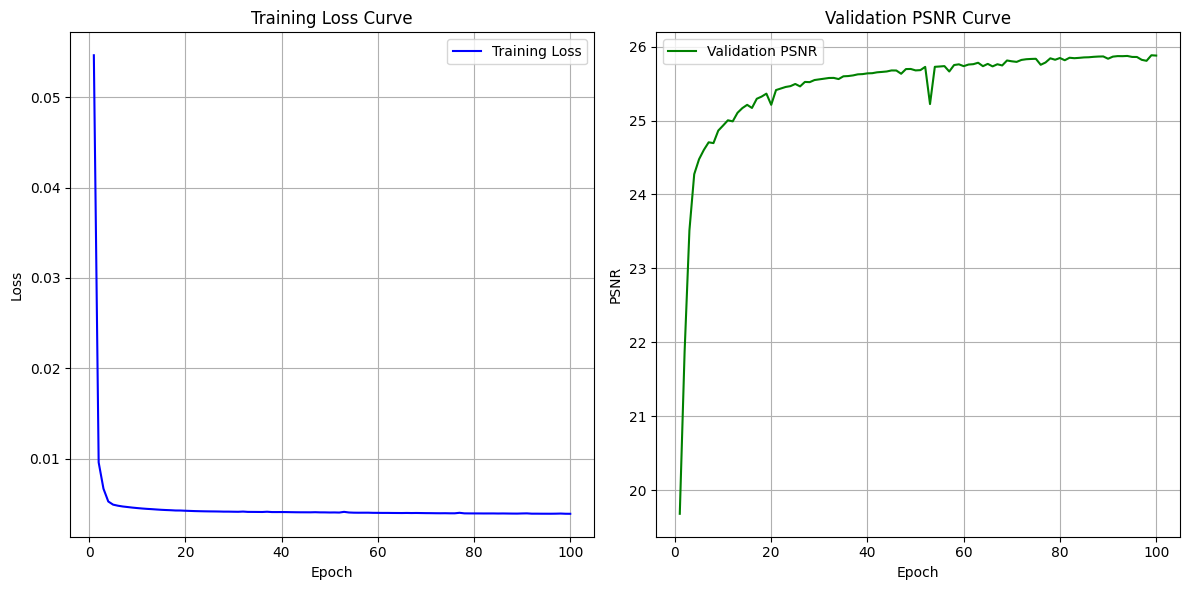

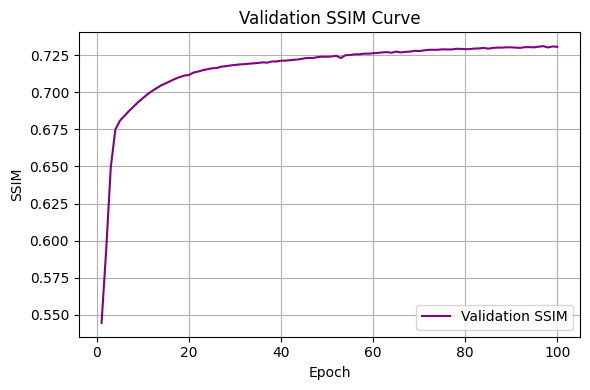

Time taken to train SRCNN: 106.41 minutes


In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("\nTraining SRCNN...")
start_time = time.time()
srcnn = train(SRCNN(), train_loader, val_loader, epochs=100)
end_time = time.time()

    # print time taken to train in minutes 
print(f"Time taken to train SRCNN: {(end_time - start_time) / 60:.2f} minutes")

In [12]:
torch.save(srcnn.state_dict(), "srcnnx4.pth")

# Inference 

In [13]:
model = SRCNN()
model.load_state_dict(torch.load("srcnnx4.pth"))
model.eval()

SRCNN(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
    (3): ReLU(inplace=True)
    (4): Conv2d(32, 3, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  )
)

In [14]:
import cv2
import numpy as np
import torch
from torchvision import transforms
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

def tensor_to_cv2_img(tensor_img):
    img = tensor_img.permute(1, 2, 0).numpy()  # [H, W, C]
    img = np.clip(img * 255.0, 0, 255).astype(np.uint8)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    return img

def tensor_to_gray_numpy(tensor_img):
    img = tensor_img.permute(1, 2, 0).numpy()
    img = np.clip(img, 0, 1)
    img_gray = cv2.cvtColor((img * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)
    return img_gray

# Loop through the first 4 examples
for idx, (lr_img, hr_img) in enumerate(val_loader):
    if idx >= 4:
        break

    lr_img = lr_img.squeeze(0)
    hr_img = hr_img.squeeze(0)

    with torch.no_grad():
        sr_img = model(lr_img.unsqueeze(0).to(device))
    sr_img = sr_img.squeeze(0).cpu()

    # Convert to OpenCV images
    lr_img_cv2 = tensor_to_cv2_img(lr_img)
    hr_img_cv2 = tensor_to_cv2_img(hr_img)
    sr_img_cv2 = tensor_to_cv2_img(sr_img)

    # Save the images
    cv2.imwrite(f"SRCNNx4lr_img_{idx+1}.png", lr_img_cv2)
    cv2.imwrite(f"SRCNNx4sr_img_{idx+1}.png", sr_img_cv2)
    cv2.imwrite(f"SRCNNx4hr_img_{idx+1}.png", hr_img_cv2)

    # Calculate metrics
    hr_gray = tensor_to_gray_numpy(hr_img)
    sr_gray = tensor_to_gray_numpy(sr_img)
    psnr_value = psnr(hr_img_cv2, sr_img_cv2, data_range=255)
    ssim_value = ssim(hr_gray, sr_gray, data_range=255)

    print(f"Example {idx+1}")
    print(f"PSNR: {psnr_value:.2f} dB")
    print(f"SSIM: {ssim_value:.4f}")
    print("=" * 30)

    # Show the images
    cv2.imshow(f'LR {idx+1}', lr_img_cv2)
    cv2.imshow(f'SR {idx+1}', sr_img_cv2)
    cv2.imshow(f'HR {idx+1}', hr_img_cv2)

    cv2.waitKey(0)
    cv2.destroyAllWindows()


Example 1
PSNR: 24.86 dB
SSIM: 0.8229
Example 2
PSNR: 24.88 dB
SSIM: 0.7863
Example 3
PSNR: 24.37 dB
SSIM: 0.6684
Example 4
PSNR: 32.35 dB
SSIM: 0.9201


### Comparision Images

In [3]:
class SRDataset(Dataset):
    def __init__(self, root_dir, transform=None, scale=4):
        self.files = sorted(os.listdir(root_dir))
        self.root_dir = root_dir
        self.transform = transform
        self.scale = scale

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        path = os.path.join(self.root_dir, self.files[idx])
        img = Image.open(path).convert('RGB')  # Change from 'L' to 'RGB' for color images

        hr = img
        lr = hr.resize((hr.width // self.scale, hr.height // self.scale), Image.BICUBIC)
        lr = lr.resize((hr.width, hr.height), Image.BICUBIC)

        if self.transform:
            hr = self.transform(hr)
            lr = self.transform(lr)

        return lr, hr

In [4]:
class SRCNN(nn.Module):
    def __init__(self):
        super(SRCNN, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=9, padding=4),  # 3 for RGB input
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 32, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 3, kernel_size=5, padding=2)  # 3 for RGB output
        )

    def forward(self, x):
        return self.model(x)

In [5]:
    # Transform to convert images to tensors
transform = transforms.ToTensor()

    # Load the full dataset (800 images assumed)
full_dataset = SRDataset("./comparison_images", transform=transform, scale=2)

    # Dataloaders
val_loader = DataLoader(full_dataset, batch_size=1)


In [6]:
model = SRCNN()
model.load_state_dict(torch.load("srcnnx4.pth"))
model.eval()

SRCNN(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
    (3): ReLU(inplace=True)
    (4): Conv2d(32, 3, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  )
)

In [8]:
import cv2
import numpy as np
import torch
from torchvision import transforms
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

def tensor_to_cv2_img(tensor_img):
    img = tensor_img.permute(1, 2, 0).numpy()  # [H, W, C]
    img = np.clip(img * 255.0, 0, 255).astype(np.uint8)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    return img

def tensor_to_gray_numpy(tensor_img):
    img = tensor_img.permute(1, 2, 0).numpy()
    img = np.clip(img, 0, 1)
    img_gray = cv2.cvtColor((img * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)
    return img_gray

# Loop through the first 4 examples
for idx, (lr_img, hr_img) in enumerate(val_loader):
    if idx >= 4:
        break

    lr_img = lr_img.squeeze(0)
    hr_img = hr_img.squeeze(0)

    with torch.no_grad():
        sr_img = model(lr_img.unsqueeze(0).to(device))
    sr_img = sr_img.squeeze(0).cpu()

    # Convert to OpenCV images
    lr_img_cv2 = tensor_to_cv2_img(lr_img)
    hr_img_cv2 = tensor_to_cv2_img(hr_img)
    sr_img_cv2 = tensor_to_cv2_img(sr_img)

    # Save the images
    cv2.imwrite(f"SRCNNx4lr_img_{idx+1}.png", lr_img_cv2)
    cv2.imwrite(f"SRCNNx4sr_img_{idx+1}.png", sr_img_cv2)
    cv2.imwrite(f"SRCNNx4hr_img_{idx+1}.png", hr_img_cv2)

    # Calculate metrics
    hr_gray = tensor_to_gray_numpy(hr_img)
    sr_gray = tensor_to_gray_numpy(sr_img)
    psnr_value = psnr(hr_img_cv2, sr_img_cv2, data_range=255)
    ssim_value = ssim(hr_gray, sr_gray, data_range=255)

    print(f"Example {idx+1}")
    print(f"PSNR: {psnr_value:.2f} dB")
    print(f"SSIM: {ssim_value:.4f}")
    print("=" * 30)

    # Show the images
    cv2.imshow(f'LR {idx+1}', lr_img_cv2)
    cv2.imshow(f'SR {idx+1}', sr_img_cv2)
    cv2.imshow(f'HR {idx+1}', hr_img_cv2)

    cv2.waitKey(0)
    cv2.destroyAllWindows()


Example 1
PSNR: 33.75 dB
SSIM: 0.9212
Example 2
PSNR: 31.56 dB
SSIM: 0.9102
Example 3
PSNR: 34.26 dB
SSIM: 0.8137
Example 4
PSNR: 33.34 dB
SSIM: 0.9205
